Taylor Salo

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import math
import pylab as plt
import seaborn as sns

# Import necessary objects from brian2
from brian2 import mV, ms, nsiemens, Mohm, nS, pamp
from brian2 import amp, siemens, volt
from brian2 import NeuronGroup, TimedArray, Synapses
from brian2 import SpikeMonitor
from brian2 import start_scope, store, restore, run

sns.set_style('darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
dirs = ['left', 'right']

# Define equations for the AdEx model (include noise)
# and equations for the AMPA and GABA synapse models
eqs =  '''
du/dt = ( -(u - u_rest) + delta_T*exp((u-vartheta_rh)/delta_T) \
    + R*(I - w - I_AMPA - I_GABA) ) / tau_m + sigma*xi*tau_m**-0.5 : volt
dw/dt = (a*(u - u_rest) - w)/tau_w : amp
I = input_current(t,i) : amp
I_AMPA = g_AMPA*(u - E_AMPA): amp
I_GABA = g_GABA*(u - E_GABA): amp
dg_AMPA/dt = -g_AMPA / tau_AMPA : siemens
dg_GABA/dt = -g_GABA / tau_GABA : siemens
'''

In [3]:
# Excitatory synapses
E_AMPA = 0*mV  # equilibrium potential of the channe
tau_AMPA = 2*ms  # speed of NT unbinding
AMPA_jump_large = 100*nsiemens  # jump in conductivity for strong exc
AMPA_jump_small = 80*nsiemens  # jump in conductivity for weak excit

# Inhibitory synapses
E_GABA = -70*mV  # equilibrium potential of the channel
tau_GABA = 6*ms  # speed of NT unbinding
GABA_jump = 80*nsiemens  # jump in conductivity for inhibitory synapse

In [4]:
start_scope()

# Create RSN neuron group. Default method is 'euler.'
RSN = NeuronGroup(2, eqs, threshold='u>theta_reset',
                  reset='u=u_r; w+= b', method='euler')

# Define parameters of the RSN AdEx model
RSN.namespace['R'] = 200*Mohm  # membrane resistance
RSN.namespace['tau_m'] = 24*ms  # membrane time constant
RSN.namespace['theta_reset'] = 35*mV  # reset threshold
RSN.namespace['u_rest'] = -65*mV  # resting potential
RSN.namespace['u_r'] = -55*mV  # reset potential
RSN.namespace['vartheta_rh'] = -52*mV  # rheobase threshold
RSN.namespace['delta_T'] = 0.8*mV  # sharpness of the action poten
RSN.namespace['tau_w'] = 88*ms  # adaptation time constant
RSN.namespace['a'] = -0.8*nS  # subthreshold adaptation const
RSN.namespace['b'] = 65*pamp  # adaptation jump after a spike
RSN.namespace['sigma'] = 0*mV  # amplitude of noise added to t

# Set initial potential to u_rest
# Use the variable in this model's namespace (see below)
RSN.u[:] = -65*mV

# Set initial adaptation to zero
RSN.w[:] = 0

In [5]:
# Create MSN neuron group. Default method is 'euler.'
MSN = NeuronGroup(2, eqs, threshold='u>theta_reset',
                  reset='u=u_r; w+= b', method='euler')

# Define parameters of the MSN AdEx model
MSN.namespace['R'] = 31.5*Mohm  # membrane resistance
MSN.namespace['tau_m'] = 50*ms  # membrane time constant
MSN.namespace['theta_reset'] = 40*mV  # reset threshold
MSN.namespace['u_rest'] = -80*mV  # resting potential
MSN.namespace['u_r'] = -55*mV  # reset potential
MSN.namespace['vartheta_rh'] = -55*mV  # rheobase threshold
MSN.namespace['delta_T'] = 2*mV  # sharpness of the action poten
MSN.namespace['tau_w'] = 100*ms  # adaptation time constant
MSN.namespace['a'] = -20*nS  # subthreshold adaptation const
MSN.namespace['b'] = 150*pamp  # adaptation jump after a spike
MSN.namespace['sigma'] = 0*mV  # amplitude of noise added to t

# Set initial potential to u_rest
# Use the variable in this model's namespace (see below)
MSN.u[:] = -80*mV

# Set initial adaptation to zero
MSN.w[:] = 0

In [6]:
# Inputs
# RSN Inputs
# Each column in this array will be input for a different neuron
input_current = np.zeros((2000, 2))

# Place an input of 200 pA to the first neuron (with index 0)
# Starting at t=101 and ending at t=1000
input_current[100:2000, 0] = 400
input_current = TimedArray(input_current*pamp, dt=1*ms)
RSN.namespace['input_current'] = input_current
del input_current

# MSN Inputs
input_current = np.zeros((2000, 4))
input_current = TimedArray(input_current*pamp, dt=1*ms)
MSN.namespace['input_current'] = input_current
del input_current

In [7]:
# Synapses
# Create strong excitatory synapses
E_strong = Synapses(RSN, MSN, on_pre='g_AMPA += AMPA_jump_large')
E_strong.connect(i=0, j=0)
E_strong.connect(i=1, j=1)

# Create weak excitatory synapses
E_weak = Synapses(RSN, MSN, on_pre='g_AMPA += AMPA_jump_small')
E_weak.connect(i=0, j=1)
E_weak.connect(i=1, j=0)

# Create inhibitory synapses
I = Synapses(MSN, on_pre='g_GABA += GABA_jump')
I.connect(i=0, j=1)
I.connect(i=1, j=0)

# Question 1

In [8]:
# Indicate what to record
spikes_RSN = SpikeMonitor(RSN)
spikes_MSN = SpikeMonitor(MSN)

# Run the simulation for 2000 ms
store(name='save')
run(2000*ms)

RT = 100 + 1000*np.min([spikes_MSN.t[spikes_MSN.i==0][4],
                        spikes_MSN.t[spikes_MSN.i==1][4]])
choice = np.argmin([spikes_MSN.t[spikes_MSN.i==0][4],
                    spikes_MSN.t[spikes_MSN.i==1][4]])
print('Turn {0} after {1} ms.'.format(dirs[choice], RT))

Turn left after 470.3 ms.


# Question 2

In [9]:
def run_trials(sig, g_gaba, rsn_ic):
    n_trials = 100
    choice = np.zeros((n_trials), dtype=int)
    RT = np.zeros((n_trials))

    for trial in range(n_trials):
        restore(name='save')

        MSN.namespace['sigma'] = sig*mV  # amplitude of noise added to t
        GABA_jump = g_gaba*nsiemens  # jump in conductivity for inhibitory synapse
        RSN.namespace['input_current'] = rsn_ic
        
        run(2000*ms)

        RT[trial] = 100 + 1000*np.min([spikes_MSN.t[spikes_MSN.i==0][4],
                                       spikes_MSN.t[spikes_MSN.i==1][4]])
        choice[trial] = np.argmin([spikes_MSN.t[spikes_MSN.i==0][4],
                                   spikes_MSN.t[spikes_MSN.i==1][4]])
    return choice, RT

In [10]:
# RSN Inputs
ic = np.zeros((2000, 2))
ic[100:2000, 0] = 400
ic = TimedArray(ic*pamp, dt=1*ms)

sig = 5
g_gaba = 80

choice, RT = run_trials(sig, g_gaba, ic)

## Part A

In [11]:
prop_corr = np.mean(choice==0)
corr_RTs = RT[choice==0]

print('{0}% of trials were correct.'.format(prop_corr*100))

97.0% of trials were correct.


## Part B

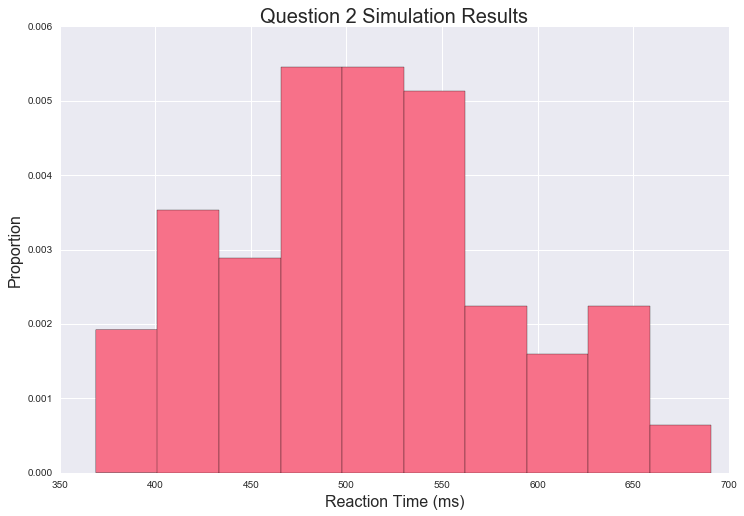

In [14]:
plt.hist(corr_RTs, normed=True,
         facecolor=sns.color_palette('husl')[0],
         edgecolor='black')
plt.title('Question {0} Simulation Results'.format(2), fontsize=20)
plt.ylabel('Proportion', fontsize=16)
plt.xlabel('Reaction Time (ms)', fontsize=16)
plt.show()

In [15]:
rt_range = np.max(corr_RTs) - np.min(corr_RTs)
print('Reaction times range from {0} to {1} ms.'.format(np.min(corr_RTs),
                                                        np.max(corr_RTs)))

print('Most common reaction time is ~500 ms.')

Reaction times range from 369.0 to 690.7 ms.
Most common reaction time is ~500 ms.


## Part C

To increase variability in RT and responses, I could increase the sigma value, which reflects the noise in the simulation.

# Question 3

96.0% of trials were correct.


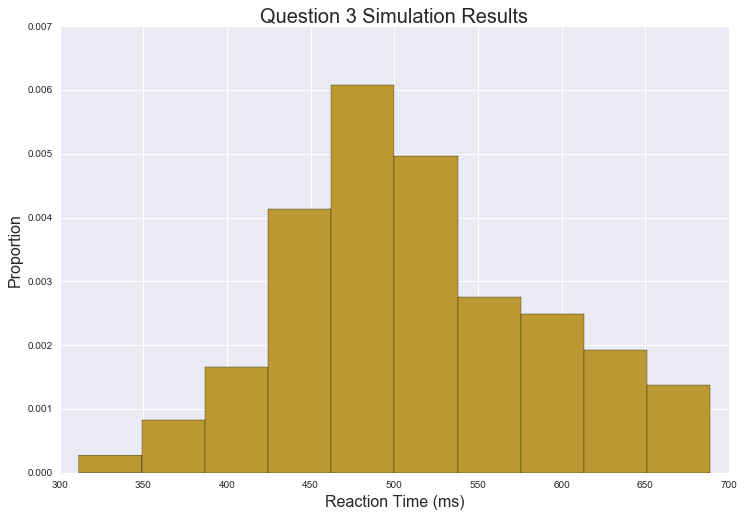

In [16]:
# RSN Inputs
ic = np.zeros((2000, 2))
ic[100:2000, 0] = 400
ic = TimedArray(ic*pamp, dt=1*ms)

sig = 5
g_gaba = 160

choice, RT = run_trials(sig, g_gaba, ic)

prop_corr = np.mean(choice==0)
corr_RTs = RT[choice==0]

print('{0}% of trials were correct.'.format(prop_corr*100))

plt.hist(corr_RTs, normed=True,
         facecolor=sns.color_palette('husl')[1],
         edgecolor='black')
plt.title('Question {0} Simulation Results'.format(3), fontsize=20)
plt.ylabel('Proportion', fontsize=16)
plt.xlabel('Reaction Time (ms)', fontsize=16)
plt.show()

In [20]:
rt_range = np.max(corr_RTs) - np.min(corr_RTs)
print('Reaction times range from {0} to {1} ms.'.format(np.min(corr_RTs),
                                                        np.max(corr_RTs)))
print('Most common reaction time is ~475 ms.')

Reaction times range from 311.4 to 688.8 ms.
Most common reaction time is ~475 ms.


The proportion of correct responses doesn't change significantly in this simulation. This is because the jump in conductance for the inhibitory synapses does not have a strong effect on accuracy. However, the RT distribution shifted downward (with faster RTs overall), because increased lateral inhibition causes the response to stabilize/occur more quickly.

# Question 4

63.0% of trials were correct.


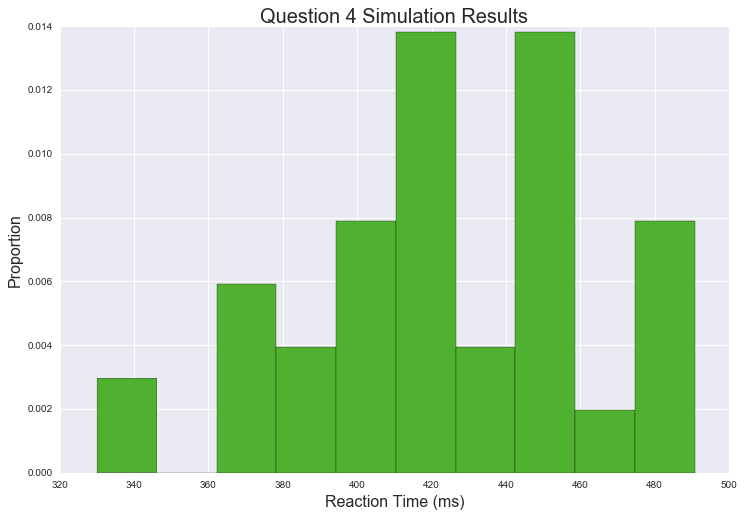

In [21]:
# RSN Inputs
ic = np.zeros((2000, 2))
ic[100:2000, 0] = 360
ic[100:2000, 1] = 200

ic = TimedArray(ic*pamp, dt=1*ms)

sig = 5
g_gaba = 80

choice, RT = run_trials(sig, g_gaba, ic)

prop_corr = np.mean(choice==0)
corr_RTs = RT[choice==0]

print('{0}% of trials were correct.'.format(prop_corr*100))

plt.hist(corr_RTs, normed=True,
         facecolor=sns.color_palette('husl')[2],
         edgecolor='black')
plt.title('Question {0} Simulation Results'.format(4), fontsize=20)
plt.ylabel('Proportion', fontsize=16)
plt.xlabel('Reaction Time (ms)', fontsize=16)
plt.show()

In [24]:
rt_range = np.max(corr_RTs) - np.min(corr_RTs)
print('Reaction times range from {0} to {1} ms.'.format(np.min(corr_RTs),
                                                        np.max(corr_RTs)))
print('Most common reaction time is ~420 ms.')

Reaction times range from 330.1 to 490.7 ms.
Most common reaction time is ~420 ms.


## Part A
Compared to Question 2, the distribution of RTs from this simulation is shifted downward. The most common RT shifts from ~500 ms to ~420 ms. Additionally, the proportion of correct responses decreases from 97% to 63%. This is because there is input to both the 'green' and 'red' neurons. If there was no noise, then the 'green' stimulus, which has a stronger input current, would consistently produce a 'left' response. However, because there is noise, the ambiguity of the input current results in lower accuracy and shorter reaction times.

## Part B
To increase accuracy in this simulation, we would need to allow for slower reaction times (i.e., decreasing speed increases accuracy). To do this, we must increase the spike threshold (S). By shifting it to a larger value, like 10, more consistency in spiking would be necessary to make a decision.